## Pricing Analysis - Aggressive Approach

### Importing Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("./Cleaned_data_pricing.csv", encoding="utf-8")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   customer_id              500 non-null    int64 
 1   cohort                   500 non-null    object
 2   price                    500 non-null    int64 
 3   price_name               500 non-null    object
 4   commercial_type          500 non-null    object
 5   invoicing_period_length  500 non-null    int64 
 6   next_invoice_at          500 non-null    object
 7   avg_3m_admin_bookings    500 non-null    int64 
 8   avg_3m_user_bookings     500 non-null    int64 
 9   city                     500 non-null    object
 10  city_id                  500 non-null    int64 
 11  specialization_name      500 non-null    object
 12  specialization_id        500 non-null    int64 
dtypes: int64(7), object(6)
memory usage: 50.9+ KB


"Recognized_mrr" should be understood here as recognized monthly reccuring revenue. 
I calculated it by dividing a price by invoicing period leng

In [4]:
df["recognized_mrr"] = df["price"] / df["invoicing_period_length"]

In [5]:
df.sample(5)

,customer_id,cohort,price,price_name,commercial_type,invoicing_period_length,next_invoice_at,avg_3m_admin_bookings,avg_3m_user_bookings,city,city_id,specialization_name,specialization_id,recognized_mrr
204,482,01/09/2023,99,GoldPro 99€ monthly,jameda_gold_pro,1,21/02/2025 00:00,0,5,Tuttlingen,12888,Zahnarzt,125,99.0
311,236,01/07/2020,1188,Jameda import jameda_gold_pro 1188.00 m12,jameda_gold_pro,12,27/09/2025 00:00,3,82,Essen,1052,Hautarzt (Dermatologe),40,99.0
95,189,01/01/2023,99,GoldPro 99€ monthly,jameda_gold_pro,1,17/02/2025 00:00,0,11,Bad Segeberg,2974,Kinder- und Jugendchirurg,61,99.0
212,495,01/02/2024,119,Platin 119€ monthly (25% discount),jameda_platin,1,28/02/2025 00:00,0,10,Hannover,1053,Zahnarzt,125,119.0
163,337,01/03/2023,68,GoldPro 68€ monthly - alternative practitioners,jameda_gold_pro,1,28/02/2025 00:00,32,8,Magdeburg,1711,Heilpraktiker,74,68.0


### Standarizing values and defining formulas
I used Min-Max normalization to improve model fitting and make potential correlations more observable.

I also defined the Customer Engagement Score (CES) to measure customer activity. In the formula, admin bookings are weighted slightly lower than user bookings because user bookings may drive additional revenue. The Price-Usage Fit Score assesses how well a customer's payment aligns with their engagement. I included the 0.01 parameter to avoid division by zero errors.
The Churn Risk Score is primarily influenced by price, with engagement acting as a counterbalance—lower pricing or higher engagement reduces churn risk.

In [6]:
def min_max_scale(column):
    return (column - column.min()) / (column.max() - column.min())

df["normalized_admin_bookings"] = min_max_scale(df["avg_3m_admin_bookings"])
df["normalized_user_bookings"] = min_max_scale(df["avg_3m_user_bookings"])
df["normalized_revenue"] = min_max_scale(df["recognized_mrr"])

df["engagement_score"] = (1 * df["normalized_admin_bookings"]) + (1.25 * df["normalized_user_bookings"])
df["price_usage_fit"] = df["normalized_revenue"] / (df["engagement_score"] + 0.01)  # Avoid division by zero
df["churn_risk_score"] = (2 * df["price_usage_fit"]) - (0.5 * df["engagement_score"])

In [7]:
df.sample()

,customer_id,cohort,price,price_name,commercial_type,invoicing_period_length,next_invoice_at,avg_3m_admin_bookings,avg_3m_user_bookings,city,city_id,specialization_name,specialization_id,recognized_mrr,normalized_admin_bookings,normalized_user_bookings,normalized_revenue,engagement_score,price_usage_fit,churn_risk_score
287,307,01/06/2020,1908,Jameda import jameda_platin 1908.00 m12,jameda_platin,12,25/07/2025 00:00,488,47,Monsheim,9615,Orthopäde & Unfallchirurg,34,159.0,0.629677,0.129477,0.814433,0.791523,1.016107,1.636452


### Dividing in Quartiles 

I divided the Churn Risk Score into quartiles to categorize customers based on their likelihood of churn into four risk categories: Low, Medium, High and Critical

In [8]:
df["churn_risk_quartiles"] = pd.qcut(df["churn_risk_score"], q=4, labels=["Low", "Medium", "High", "Critical"])

### Holdplace for further EDA - do some graphs, check the distribution etc. 

### Optimized Price and New Churn Risk Score Calculated

The value assigned to medium_churn_threshold represents the highest churn risk score within the Medium segment, meaning it equals to the customer with the highest churn likelihood still classified as "Medium" risk. This basically sets the cap on that threshold, ensuring optimized pricing won't raise churn above its level.

In [9]:
medium_churn_threshold = df[df["churn_risk_quartiles"] == "Medium"]["churn_risk_score"].max()
medium_churn_threshold

14.407525437066738

I've added minimal and maximal revenue/recognized mrr to be able to later map the optimized price from normalized values back to absolute revenue figures

In [10]:
df["normalized_engagmnet"] = min_max_scale(df["engagement_score"])
min_revenue, max_revenue = df["recognized_mrr"].min(), df["recognized_mrr"].max()

### Computing Optimal Price
I adjusted prices for customers in the Low and Medium churn risk segments while keeping others unchanged. The maximum price is capped at 195 (Platinum Package). The threshold for price increases is set at a churn risk score of 14.4075 (described before), which corresponds to the last customer in the Medium risk category. If the calculated price exceeds $195, the function caps it and recalculates the churn risk score.

In [12]:
def compute_optimal_price(row):
    if row["churn_risk_quartiles"] not in ["Low", "Medium"] or row["recognized_mrr"] == 1:
        return row["recognized_mrr"], row["churn_risk_score"]

    engagement_score_normalized = row["normalized_engagmnet"]
    target_price_usage_fit = (medium_churn_threshold + (0.5 * engagement_score_normalized)) / 2
    new_normalized_revenue = target_price_usage_fit * (engagement_score_normalized + 0.01)
    new_price = (new_normalized_revenue * (max_revenue - min_revenue)) + min_revenue

    if new_price > 195:
        new_price = 195
        capped_normalized_revenue = (new_price - min_revenue) / (max_revenue - min_revenue)
        new_normalized_price_usage_score = capped_normalized_revenue / (engagement_score_normalized + 0.01)
        new_churn_risk_score = (2 * new_normalized_price_usage_score) - (0.5 * engagement_score_normalized)
    else:
        new_churn_risk_score = medium_churn_threshold

    new_price = max(new_price, row["recognized_mrr"])
    new_churn_risk_score = max(new_churn_risk_score, row["churn_risk_score"])

    return round(new_price, 2), round(new_churn_risk_score, 4)

df[["optimized_price", "new_churn_risk_score"]] = df.apply(
    lambda row: compute_optimal_price(row), axis=1, result_type="expand")

In [13]:
df.sort_values(["new_churn_risk_score"]).head(1)

,customer_id,cohort,price,price_name,commercial_type,invoicing_period_length,next_invoice_at,avg_3m_admin_bookings,avg_3m_user_bookings,city,...,normalized_admin_bookings,normalized_user_bookings,normalized_revenue,engagement_score,price_usage_fit,churn_risk_score,churn_risk_quartiles,normalized_engagmnet,optimized_price,new_churn_risk_score
38,142,01/10/2024,1,GoldPro 1€ monthly,jameda_gold_pro,1,28/02/2025 00:00,290,19,Zweibrücken,...,0.374194,0.052342,0.0,0.439621,0.0,-0.21981,Low,0.267903,1.0,-0.21981


### Dividing new churn risk into quartiles - to do if needed

### Analysis on viability and impact of the price change
I selected customers in the Medium and Low churn risk segments and calculated their total current revenue (price change only involved them). Then, I calculated the total revenue based on the optimized price. I sorted these customers by new churn risk score in descending order for removing higher-risk customers first.

Next, the function iteratively removes customers from the dataset, reducing revenue by their optimized price, until the remaining revenue matches the current total. I counted the number of customers removed to determine the break-even churn count (how many of these customers would need to churn for the investment to not make sense). Finally, I calculated the revenue difference between the optimized and current revenue and the break-even churn rate for the selected segment.

In [14]:
df_filtered = df[df["churn_risk_quartiles"].isin(["Medium", "Low"])].copy()
total_current_revenue = df_filtered["recognized_mrr"].sum()
total_optimized_revenue = df_filtered["optimized_price"].sum()

df_filtered = df_filtered.sort_values(by="new_churn_risk_score", ascending=False)

cumulative_churned = 0
cumulative_new_revenue = total_optimized_revenue

for index, row in df_filtered.iterrows():
    if cumulative_new_revenue <= total_current_revenue:
        break  
    
    cumulative_new_revenue -= row["optimized_price"]
    cumulative_churned += 1


revenue_difference = total_optimized_revenue - total_current_revenue

print(f"Total Current Revenue (Medium & Low Risk): {total_current_revenue:,.2f}")
print(f"Total Optimized Revenue (Medium & Low Risk / Before Churn): {total_optimized_revenue:,.2f}")
print(f"Revenue Increase (Optimized - Current): {revenue_difference:,.2f}")
print(f"Break-Even Churn Count (Medium & Low Risk): {cumulative_churned} customers")
print(f"Break-Even Churn Rate (Medium & Low Risk): {cumulative_churned / len(df_filtered):.2%}")

Total Current Revenue (Medium & Low Risk): 22,882.72
Total Optimized Revenue (Medium & Low Risk / Before Churn): 34,038.10
Revenue Increase (Optimized - Current): 11,155.38
Break-Even Churn Count (Medium & Low Risk): 97 customers
Break-Even Churn Rate (Medium & Low Risk): 38.80%


In [15]:
total_current_revenue = df["recognized_mrr"].sum()
total_optimized_revenue = df["optimized_price"].sum()
total_revenue_increase = df["optimized_price"].sum() - df["recognized_mrr"].sum()
total_revenue_change_perc = ((total_optimized_revenue / total_current_revenue) - 1)*100

print(f"Total Current Revenue: {total_current_revenue:,.2f}")
print(f"Total Optimized Revenue: {total_optimized_revenue:,.2f}")
print(f"Total Revenue Increase (Optimized - Current): {total_revenue_increase:,.2f}")
print(f"Total Revenue Change in %: {total_revenue_change_perc:,.2f}")

Total Current Revenue: 50,620.22
Total Optimized Revenue: 61,775.60
Total Revenue Increase (Optimized - Current): 11,155.38
Total Revenue Change in %: 22.04


## Final Remarks
After applying the optimized pricing model, total revenue increased from 50,620.22 to 61,775.60, a 22.04% increase.

Among customers in the Medium and Low churn risk segments, revenue before churn increased from 22,882.72 to 34,038.10.

To maintain the original revenue level after churn (optimized revenue = current revenue), 97 customers in the Medium and Low Risk segments (38.80% churn rate within these segments) would need to leave.

In [16]:
df.head(1)

,customer_id,cohort,price,price_name,commercial_type,invoicing_period_length,next_invoice_at,avg_3m_admin_bookings,avg_3m_user_bookings,city,...,normalized_admin_bookings,normalized_user_bookings,normalized_revenue,engagement_score,price_usage_fit,churn_risk_score,churn_risk_quartiles,normalized_engagmnet,optimized_price,new_churn_risk_score
0,399,01/07/2024,99,GoldPro 99€ monthly,jameda_gold_pro,1,28/02/2025 00:00,0,15,Hessen,...,0.0,0.041322,0.505155,0.051653,8.193527,16.361228,High,0.031477,99.0,16.361228


### Additional Useful Information Preperation

##### Assigning risk segments to optimized prices - I maintained the original churn risk segmentation thresholds but applied them to the updated churn risk scores.

In [17]:
thresholds = df['churn_risk_score'].quantile([0.25, 0.50, 0.75]).tolist()
q1, q2, q3 = thresholds

def assign_risk_category(score, q1, q2, q3):
    if score <= q1:
        return 'Low'
    elif score <= q2:
        return 'Medium'
    elif score <= q3:
        return 'High'
    else:
        return 'Critical'

df['new_churn_risk_segments'] = df['new_churn_risk_score'].apply(lambda x: assign_risk_category(x, q1, q2, q3))

In [18]:
df.head(1)

,customer_id,cohort,price,price_name,commercial_type,invoicing_period_length,next_invoice_at,avg_3m_admin_bookings,avg_3m_user_bookings,city,...,normalized_user_bookings,normalized_revenue,engagement_score,price_usage_fit,churn_risk_score,churn_risk_quartiles,normalized_engagmnet,optimized_price,new_churn_risk_score,new_churn_risk_segments
0,399,01/07/2024,99,GoldPro 99€ monthly,jameda_gold_pro,1,28/02/2025 00:00,0,15,Hessen,...,0.041322,0.505155,0.051653,8.193527,16.361228,High,0.031477,99.0,16.361228,High


##### Adding % change from current_price to optimized_price

In [19]:
df["price_change_%"] = ((df["optimized_price"] / df["recognized_mrr"]) - 1)*100

In [20]:
df.sort_values("price_change_%").head(5)

,customer_id,cohort,price,price_name,commercial_type,invoicing_period_length,next_invoice_at,avg_3m_admin_bookings,avg_3m_user_bookings,city,...,normalized_revenue,engagement_score,price_usage_fit,churn_risk_score,churn_risk_quartiles,normalized_engagmnet,optimized_price,new_churn_risk_score,new_churn_risk_segments,price_change_%
315,143,01/01/2020,844,Dynamic GoldPro 950€ annual (20% discount),jameda_gold_pro,12,09/01/2025 00:00,0,16,Herne,...,0.357388,0.055096,5.490138,10.952728,Medium,0.033576,70.33,14.407500,Medium,-0.004739
0,399,01/07/2024,99,GoldPro 99€ monthly,jameda_gold_pro,1,28/02/2025 00:00,0,15,Hessen,...,0.505155,0.051653,8.193527,16.361228,High,0.031477,99.00,16.361228,High,0.000000
314,380,01/08/2020,1056,Jameda import jameda_gold_pro 1056.00 m12,jameda_gold_pro,12,25/08/2025 00:00,0,14,Hagen,...,0.448454,0.048209,7.704149,15.384193,High,0.029379,88.00,15.384193,High,0.000000
313,52,01/10/2020,1056,Jameda import jameda_gold_pro 1056.00 m12,jameda_gold_pro,12,06/12/2025 00:00,0,4,Köln,...,0.448454,0.013774,18.863112,37.719338,Critical,0.008394,88.00,37.719338,Critical,0.000000
312,44,01/03/2020,1188,Jameda import jameda_gold_pro 1188.00 m12,jameda_gold_pro,12,12/03/2025 00:00,0,2,Landau in der Pfalz,...,0.505155,0.006887,29.913725,59.824006,Critical,0.004197,99.00,59.824006,Critical,0.000000


#### How many customers are in each segment after optimizing the price

In [21]:
df["new_churn_risk_segments"].value_counts()

new_churn_risk_segments
Medium      220
High        125
Critical    125
Low          30
Name: count, dtype: int64

#### Data Vizualitzation
Data Vizualization done to check up data distribution and the impact of the approach

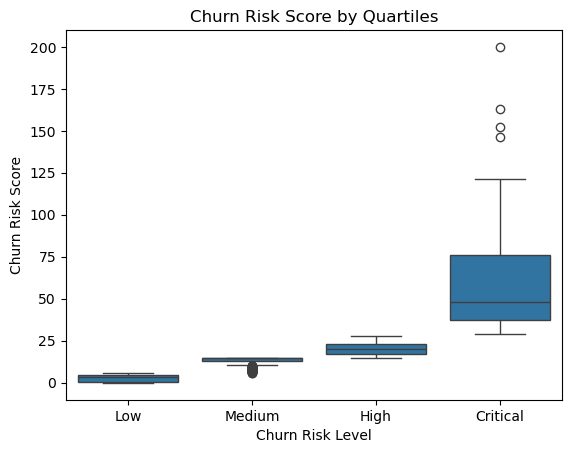

In [22]:
order = ["Low", "Medium", "High", "Critical"]
sns.boxplot(x=df["new_churn_risk_segments"], y=df["new_churn_risk_score"], order = order)
plt.title("Churn Risk Score by Quartiles")
plt.xlabel("Churn Risk Level")
plt.ylabel("Churn Risk Score")
plt.show()

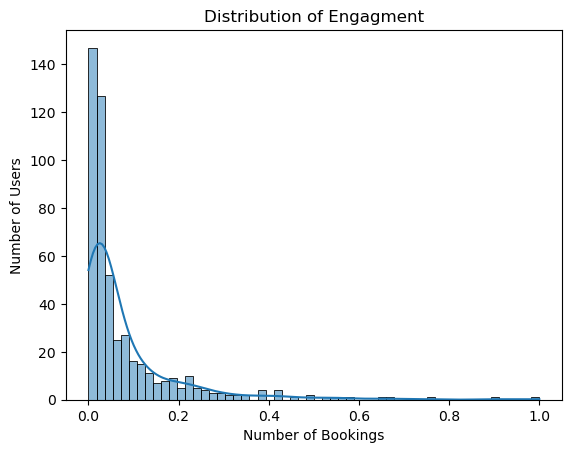

In [23]:
sns.histplot(df["normalized_engagmnet"], kde=True)
plt.title("Distribution of Engagment")
plt.xlabel("Number of Bookings")
plt.ylabel("Number of Users")
plt.show()

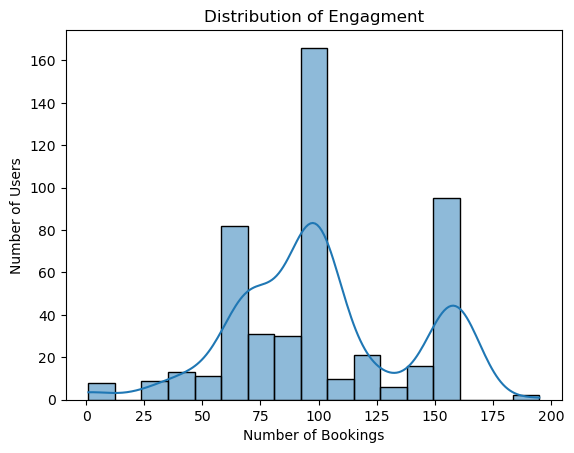

In [24]:
sns.histplot(df["recognized_mrr"], kde=True)
plt.title("Distribution of Engagment")
plt.xlabel("Number of Bookings")
plt.ylabel("Number of Users")
plt.show()

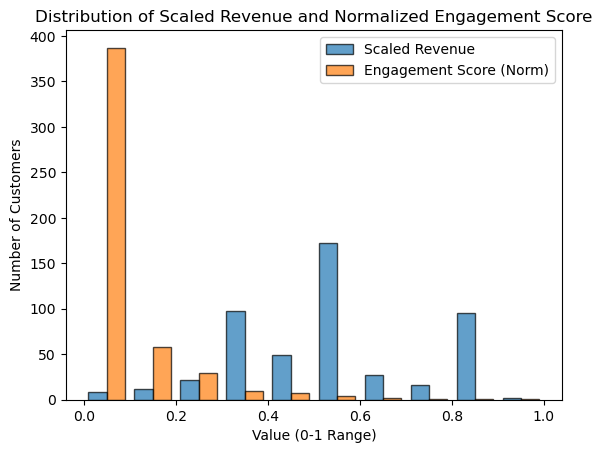

In [25]:
# Define bin edges for histogram
bins = np.linspace(0, 1, 11)  # 10 bins from 0 to 1

# Plot histogram with grouped bars
plt.hist([df["normalized_revenue"], df["normalized_engagmnet"]], bins=bins, label=["Scaled Revenue", "Engagement Score (Norm)"], alpha=0.7, edgecolor="black")

# Add labels and title
plt.xlabel("Value (0-1 Range)")
plt.ylabel("Number of Customers")
plt.title("Distribution of Scaled Revenue and Normalized Engagement Score")
plt.legend()

# Show the plot
plt.show()

In [26]:
df.sort_values(by="normalized_revenue", ascending = True).sample(1)

,customer_id,cohort,price,price_name,commercial_type,invoicing_period_length,next_invoice_at,avg_3m_admin_bookings,avg_3m_user_bookings,city,...,normalized_revenue,engagement_score,price_usage_fit,churn_risk_score,churn_risk_quartiles,normalized_engagmnet,optimized_price,new_churn_risk_score,new_churn_risk_segments,price_change_%
14,217,01/07/2022,119,Jameda import jameda_gold_pro 119.00 m1,jameda_gold_pro,1,18/02/2025 00:00,775,68,Lehrberg,...,0.608247,1.23416,0.488882,0.360684,Low,0.752093,195.0,2.2483,Low,63.865546


In [27]:
df_copy = df[[
    "customer_id", "cohort", "recognized_mrr", "price_name", "avg_3m_admin_bookings", "avg_3m_user_bookings",
    "churn_risk_score", "churn_risk_quartiles",
    "optimized_price", "new_churn_risk_score", "new_churn_risk_segments", "price_change_%"
]].copy()

In [28]:
df.to_csv("./My Projects/Full_Table_Konstanty-Mrozowski.csv", index = False)
df_copy.to_csv("./My Projects/Analysis_Results_Konstanty-Mrozowski.csv", index = False)